# Import libraries

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
import time
import geohash as gh
from sklearn.metrics import mean_squared_error, r2_score
from string import punctuation
from collections import Counter
from keras import Sequential
from keras.layers import Embedding,LSTM,Dense,Conv1D,MaxPooling1D
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint

# Useful functions

In [153]:
def remove_punctuation(comment):
    return ''.join([c for c in comment if c not in punctuation])
def create_vocabulary(comments):
    all_text = ' '.join(comments)
    # create a list of words
    words = all_text.split()
    # Count all the words using Counter Method
    count_words = Counter(words)

    total_words = len(words)
    sorted_words = count_words.most_common(total_words)
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
    return vocab_to_int
def word_encoder(vocabulary,comment):
    return [vocabulary[word] for word in comment.split()]
def treat_outlier(df_series,sigma):
    Q1=df_series.quantile(0.25)
    Q3=df_series.quantile(0.75)
    IQR=Q3-Q1
    Lower_Whisker = Q1-sigma*IQR
    Upper_Whisker = Q3+sigma*IQR
    return Lower_Whisker,Upper_Whisker
def create_seq(comment,comment_len,seq_len):
    if comment_len<seq_len:
        return list(np.zeros(seq_len-comment_len))+comment
    else:
        return comment[:seq_len]

# Data preparation

In [2]:
#load the dataset
train_data = pd.read_csv('data/train.csv')

In [4]:
train_data.columns = ['score','comment']

In [7]:
train_data['sentiment_polarity'] = np.where(train_data['score']==1,0,1)

In [10]:
train_data = train_data.drop('score',axis=1)

In [14]:
train_data.to_csv('data/train.csv',index=False)

In [15]:
#do the same for test_data
test_data = pd.read_csv('data/test.csv')
test_data.columns = ['score','comment']
test_data['sentiment_polarity']=np.where(test_data['score']==1,0,1)
test_data = test_data.drop('score',axis=1)
test_data.to_csv('data/test.csv',index=False)

# Data preprocess

In [83]:
train_data = pd.read_csv('data/train.csv')

In [87]:
df = train_data.sample(frac=0.1,replace=False,random_state=1)

In [88]:
#lowercase all the reviews
df['comment']=[i.lower() for i in df['comment']]
    

In [89]:
#remove punctuation
df['comment'] = [remove_punctuation(i) for i in df['comment']]

In [90]:
#create vocabulary
vocabulary = create_vocabulary(df['comment'])

In [91]:
#encode the words

df['comment'] = [word_encoder(vocabulary,i) for i in df['comment']]

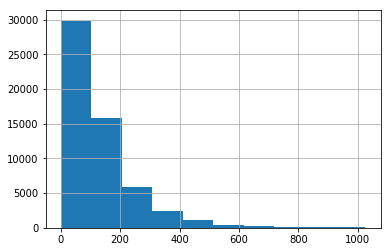

count    56000.000000
mean       132.195357
std        122.395766
min          1.000000
25%         51.000000
50%         96.000000
75%        172.000000
max       1025.000000
Name: comment_len, dtype: float64

In [92]:
#analyze review length and remove outliers
df['comment_len'] = [len(x) for x in df['comment']]
df['comment_len'].hist()
plt.show()
df['comment_len'].describe()

In [95]:
lower,upper = treat_outlier(df['comment_len'],3)

In [98]:
df = df.loc[df['comment_len']<upper]

In [113]:
#create inputs for embedding layer
seq_len = 200
df['comment_input'] = df.apply(lambda x: create_seq(x['comment'],x['comment_len'],seq_len),axis=1)

,comment,sentiment_polarity,comment_len,comment_input
39658,"[19, 62, 182, 58, 370, 45, 19, 160, 44, 2, 93,...",1,57,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
406546,"[15, 30, 75, 41, 120, 359, 2, 16, 1, 190, 8, 7...",1,157,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
238894,"[33, 29, 17, 1878, 20, 218, 25, 74, 95, 20, 13...",0,73,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
453534,"[3372, 1, 1503, 1512, 7073, 655, 28081, 24, 1,...",0,24,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
484639,"[250, 529, 303, 31, 5, 28082]",1,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
87433,"[4648, 1, 453, 12, 857, 3267, 11, 5, 201, 681,...",1,66,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
115310,"[15, 30, 1155, 38, 19, 131, 337, 358, 2, 57, 1...",0,60,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
463156,"[490, 40, 148, 6, 34393, 14, 209, 4, 808, 8, 2...",0,33,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
455506,"[14, 25, 473, 2151, 76, 1, 48, 14, 645, 10, 24...",0,197,"[0.0, 0.0, 0.0, 14, 25, 473, 2151, 76, 1, 48, ..."
385063,"[1562, 54, 1, 3218, 148, 1, 3819, 44, 27, 399,...",0,61,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [205]:
y_train.shape

(44080,)

In [160]:
#create dataset for training, val, test
data = df
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
data_validation,data_test = train_test_split(data_test, test_size=0.5, random_state=43)
print('Split the data into training set with size of {}, validation set with size of {}, test set with size of {}'.format(len(data_train), len(data_validation), len(data_test)))

Split the data into training set with size of 44080, validation set with size of 5510, test set with size of 5510


# Build Model

In [195]:
X_train,y_train = data_train['comment_input'],data_train['sentiment_polarity']
X_validation,y_validation = data_validation['comment_input'],data_validation['sentiment_polarity']

In [204]:
X_train = np.array(X_train.tolist())
y_train = np.array(y_train.tolist())
X_validation = np.array(X_validation.tolist())
y_validation = np.array(y_validation.tolist())

## A. LSTM model 

In [216]:
#build LSTM model

top_words = len(vocabulary)+1
max_review_length=200
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [217]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           4628224   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 4,681,525
Trainable params: 4,681,525
Non-trainable params: 0
_________________________________________________________________


In [218]:
model.fit(X_train, y_train, epochs=1, batch_size=32,verbose = 1,validation_data=(X_validation,y_validation))

Train on 44080 samples, validate on 5510 samples
Epoch 1/1
44080/44080 [==============================] - 232s 5ms/step - loss: 0.3855 - accuracy: 0.8333 - val_loss: 0.2979 - val_accuracy: 0.8788


## B. 1dCNN+LSTM model

In [221]:
#build 1dcnn+lstm
embedding_vecor_length = 32
top_words = len(vocabulary)+1
max_review_length=200
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           4628224   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 4,684,629
Trainable params: 4,684,629
Non-trainable params: 0
_________________________________________________________________
None


In [224]:
filepath="weights_best_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]
model.fit(X_train, y_train, epochs=5, batch_size=32,callbacks = callbacks_list, verbose = 1,validation_data=(X_validation,y_validation))

Train on 44080 samples, validate on 5510 samples
Epoch 1/5
44080/44080 [==============================] - 164s 4ms/step - loss: 0.3246 - accuracy: 0.8593 - val_loss: 0.2421 - val_accuracy: 0.9000
Epoch 2/5
44080/44080 [==============================] - 152s 3ms/step - loss: 0.1645 - accuracy: 0.9397 - val_loss: 0.2379 - val_accuracy: 0.9094
Epoch 3/5
44080/44080 [==============================] - 152s 3ms/step - loss: 0.0997 - accuracy: 0.9654 - val_loss: 0.2563 - val_accuracy: 0.9122
Epoch 4/5
44080/44080 [==============================] - 152s 3ms/step - loss: 0.0638 - accuracy: 0.9784 - val_loss: 0.2949 - val_accuracy: 0.9067
Epoch 5/5
44080/44080 [==============================] - 164s 4ms/step - loss: 0.0461 - accuracy: 0.9851 - val_loss: 0.3249 - val_accuracy: 0.9015


# Evaluation

In [225]:
X_test,y_test = data_test['comment_input'],data_test['sentiment_polarity']
X_test = np.array(X_test.tolist())
y_test = np.array(y_test.tolist())

In [234]:
x =X_test[0].reshape((1,200))

In [235]:
y_pred = model.predict(x)

In [236]:
y_pred

array([[0.04153999]], dtype=float32)